In [79]:
import cv2
import numpy as np
import os
import skops.io as sio
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from face_segmenter import segment_image,rgb2gray, next_pyramid_step
import matplotlib.pyplot as plt
import random

# Entrenamiento

In [2]:
csv_path = "/media/nacho/datasets/CelebA/list_bbox_celeba.csv"
images_dir = "/media/nacho/datasets/CelebA/img_align_celeba/img_align_celeba"

images_properties = pd.read_csv(csv_path,sep=",",nrows=100000)

In [3]:
x1 = 45
y1 = 85
w1 = 90
h1 = 90
n_clusters = 128

In [4]:
def sharpen_image(image):
    sharpening = np.array([[-1,-1,-1],[-1,9.5,-1],[-1,-1,-1]])
    image = cv2.filter2D(image,-1,sharpening)
    return image

In [5]:
def change_brightness(image):
    bright = np.ones(image.shape,dtype=int) * (np.random.random() * 100 - 50)
    return np.clip(image + bright.astype(int),0,255) 

In [6]:
faces_list = []
faces_list_augmented = []
for _,image in images_properties.iterrows():
    image_path,bbox1,bbox2,bbox3,bbox4 = image.tolist()
    image_path = os.path.join(images_dir,image_path)
    if not os.path.exists(image_path): continue
    
    img = cv2.imread(image_path)
    img = rgb2gray(img)
    face = img[y1:y1+h1,x1:x1+w1]
    
    face = cv2.resize(face,(32,32))
    face_f = cv2.flip(face,1)
    
    faces_list.append(face)    
    # faces_list_augmented.append(face_f)

    # faces_list_augmented.append(sharpen_image(face))
    # faces_list_augmented.append(sharpen_image(face_f))

    # faces_list_augmented.append(change_brightness(face))
    # faces_list_augmented.append(change_brightness(face_f))


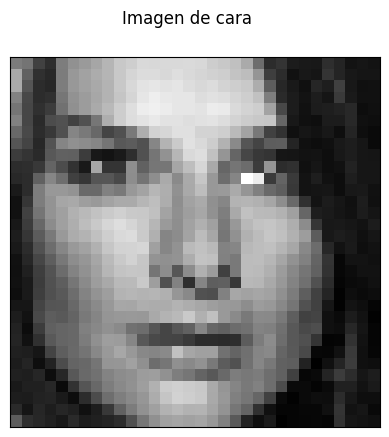

In [78]:
fig = plt.imshow(faces_list[33],cmap="gray")
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.suptitle("Imagen de cara")
plt.show()

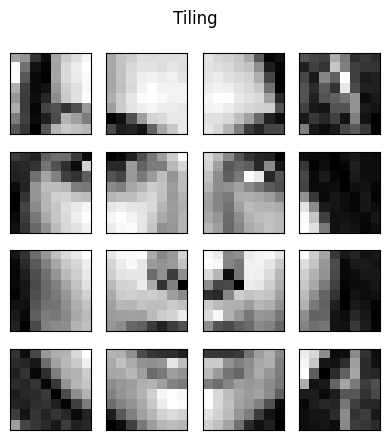

In [76]:
fig, axes = plt.subplots(ncols=4,nrows=4,figsize=(4, 4.5))
tiles = segment_image(faces_list[33],8)[0]
for i in range(4):
    for j in range(4):
        axes[i,j].imshow(tiles[4*i+j],cmap="gray")
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)

plt.suptitle("Tiling")
plt.tight_layout()

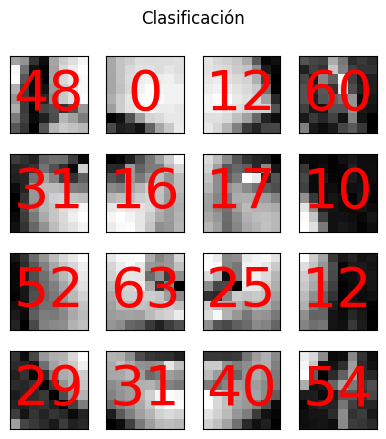

In [80]:
fig, axes = plt.subplots(ncols=4,nrows=4,figsize=(4, 4.5))
tiles = segment_image(faces_list[33],8)[0]
for i in range(4):
    for j in range(4):
        axes[i,j].imshow(tiles[4*i+j],cmap="gray")
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        axes[i,j].text(3.5,3.5,random.randint(0,64),fontsize=40,color="red",verticalalignment="center",horizontalalignment="center")

plt.suptitle("Clasificación")
plt.tight_layout()

In [43]:
tile_list = []
for face in faces_list:
    tiles,_ = segment_image(face,8)
    tile_list.append(tiles)

tiles_np = np.concatenate(tile_list)

In [44]:
tile_list = []
for face in faces_list_augmented:
    tiles,_ = segment_image(face,8)
    tile_list.append(tiles)

tiles_augmented_np =  np.concatenate(tile_list)
del tile_list

In [45]:
import random
caltech_images_path = "/media/nacho/datasets/256_ObjectCategories"

categories = os.listdir(caltech_images_path)
banned = ["001.ak47","038.chimp","032.cartman","051.cowboy-hat","119.jesus-christ","112.human-skeleton"]

categories_tree = dict()
for category in categories:
    if category in banned: continue
    categories_tree[category] = os.listdir(caltech_images_path + "/" + category)

caltech_images_list = []
while len(caltech_images_list) < 10_000:
    category = random.choice(categories)
    if category in banned: continue
    cal_img_list = categories_tree[category]

    image_name = random.choice(cal_img_list)
    img_npy = cv2.imread(os.path.join(caltech_images_path,category,image_name))

    img_npy = rgb2gray(img_npy)
    for i in range(10):
        img_npy = next_pyramid_step(img_npy,0.9)
        subregiones,_ = segment_image(img_npy,8)
        caltech_images_list.append(subregiones)



In [46]:
caltech_images =  np.concatenate(caltech_images_list)
print(caltech_images.shape)

In [47]:
train_tiles_np = np.concatenate([tiles_np,caltech_images])

In [48]:
#pipe = Pipeline([('kmeans', KMeans(n_clusters,n_init=1,verbose=True))])
pipe = KMeans(n_clusters=n_clusters,n_init=5)
pipe.fit(train_tiles_np.reshape(-1,64))

KMeans(n_clusters=128, n_init=5)

In [49]:
from joblib import dump
with open("models/pipe_kmeans64.sio","+wb") as f:
    obj = sio.dumps(pipe)
    f.write(obj)

In [50]:
from joblib import load
with open("models/pipe_kmeans64.sio","br") as f:
    obj = f.read()
    unknown_types = sio.get_untrusted_types(data=obj)
    pipe = sio.loads(obj,trusted=unknown_types)


## Conteo

In [51]:
y_prime = pipe.predict(np.concatenate([tiles_np,tiles_augmented_np]).reshape(-1,64))
y_prime_pos = y_prime.reshape(-1,16)
P_q_cara,_ = np.histogram(y_prime,bins=range(0,n_clusters+1))

In [52]:
P_pos_q_cara_list = []
for i in range(y_prime_pos.shape[1]):
    P_pos_q_cara_i, _ = np.histogram(y_prime_pos[:,i],bins=range(0,n_clusters+1)) 
    P_pos_q_cara_list.append(P_pos_q_cara_i)

P_pos_q_cara = np.stack(P_pos_q_cara_list)

In [53]:
np.save("counts/pipe_kmeans64/P_q_cara.npy",P_q_cara)
np.save("counts/pipe_kmeans64/P_pos_q_cara.npy",P_pos_q_cara)

In [ ]:
natural_images_path = "/media/nacho/datasets/natural_images"

natural_images_list = []

for data_folder in os.listdir(natural_images_path):
    if data_folder == "person": continue
    for image in os.listdir(os.path.join(natural_images_path,data_folder)):
        img_npy = cv2.imread(os.path.join(natural_images_path,data_folder,image))
        img_npy = rgb2gray(img_npy)
        subregiones,_ = segment_image(img_npy,8)
        natural_images_list.append(subregiones)

natural_images = np.concatenate(natural_images_list)
del natural_images_list

In [ ]:
nocara_images = np.concatenate([natural_images,caltech_images])

In [54]:
y_naturales_prime = pipe.predict(nocara_images.reshape(-1,64))
P_q_nocara,_ = np.histogram(y_naturales_prime,bins=range(0,n_clusters+1))
np.save("counts/pipe_kmeans64/P_q_nocara.npy",P_q_nocara)

## Calcular el resultado

In [33]:
P_norm_q_nocara = P_q_nocara / P_q_nocara.sum()

In [34]:
P_norm_q_cara = P_q_cara / P_q_cara.sum()

In [35]:
P_pos_q_cara.sum(axis=0)

array([32094, 54222, 25041, 45680, 31461, 32514, 30685, 18467, 19298,
       16893, 24972, 37314, 14561, 16127, 13171, 46596, 17023, 15332,
       15051, 21556, 13576,  6964, 15547, 35692, 14952, 19123, 54018,
       11622, 15052,  7972, 16764, 37307, 34299, 28803, 52571, 12367,
       18361, 40813, 24377, 15683, 35383, 14224, 25451, 17477, 33925,
       47754, 14303, 14099, 16891, 30699, 10569, 30346, 18090, 48605,
       25200, 12136, 11798, 13123, 40996, 49845, 27492, 29572, 14042,
       14059])

In [36]:
P_norm_pos_q_cara = P_pos_q_cara / P_pos_q_cara.sum(axis=0)

In [37]:
P_norm_pos_q_cara.shape

(16, 64)

In [38]:
test = np.asarray([10,20,30,40,50,60])

In [39]:
test

array([10, 20, 30, 40, 50, 60])

In [41]:
P_norm_q_nocara[20],P_norm_q_nocara[30],P_norm_q_nocara[40]

(0.008417508417508417, 0.0016835016835016834, 0.005050505050505051)

In [42]:
den = np.prod(P_norm_q_nocara[test]/ (16*64)) 

In [43]:
np.prod(P_norm_pos_q_cara[np.arange(0,64,1,dtype=int),test])

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (64,) (6,) 

In [44]:
num = np.prod(P_norm_pos_q_cara[np.arange(0,6,1,dtype=int),test]) * np.prod(P_norm_q_cara[test])